In [1]:
# Importamos todas las bibliotecas necesarias

import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [2]:
class DoubleConv(torch.nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


class Down(torch.nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(torch.nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x =  self.conv(x)

        x = torch.softmax(x, dim=1)
        return x


class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



In [3]:
# Probamos el modelo
input_image = torch.rand((1,3,512,512))
model = UNet(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 512, 512])


In [ ]:
# Defino los path de las imagenes y las mascaras
path_images = '/home/21908437salomea/Modulo_Vision/Modulo_Vision/Image/'
path_masks = '/home/21908437salomea/Modulo_Vision/Modulo_Vision/Mask/'


In [5]:
# Vamos a crear una clase para cargar las imagenes y las mascaras
class FloodDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform

        self.images = os.listdir(images_path)
        self.masks = os.listdir(masks_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.images_path, self.images[idx])
        mask_name = os.path.join(self.masks_path, self.masks[idx])

        image = Image.open(image_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [6]:
# Ya podemos crear el dataset
# Definimos la transformacion
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Cargamos el dataset
dataset = FloodDataset(images_path=path_images, masks_path=path_masks, transform=transform)

# Dividimos el dataset en train y test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1234))

# Cargamos el dataset en un dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [7]:
# Inicializamos el generador de numeros aleatorios
random.seed(1234)
torch.manual_seed(1234)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print("GPU is available")
    num_workers = torch.cuda.device_count() * 4
    print(f"Number of workers: {num_workers}")

GPU is available
Number of workers: 4


In [9]:
# Vamos a cargar los datos en la GPU

model = UNet(n_channels=3, n_classes=1).to(device)

In [10]:
LEARNING_RATE = 0.00001 
BATCH_SIZE = 4

train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(n_channels=3, n_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Usamos el IOU para calcular el error
def iou_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total = (y_true + y_pred).sum()
    union = total - intersection
    iou = intersection / union
    return iou

In [ ]:
# Usamos el indice de Jaccard para calcular el error
def jaccard_index(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total = (y_true + y_pred).sum()
    union = total - intersection
    jaccard = intersection / union
    return jaccard


In [ ]:
# Usamos el dice para calcular el error
def dice_coefficient(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total = (y_true + y_pred).sum()
    dice = 2 * intersection / total
    return dice

In [14]:
torch.cuda.empty_cache()

In [15]:
# Vamos a definir un bloque de entrenamiento y evaluacion del modelo guaradando los datos para las graficas de perdida y accuracy utilizando el IOU
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10):
    train_losses = []
    test_losses = []
    iou_scores = []
    jaccard_scores = []
    dice_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluamos el modelo
        model.eval()
        running_loss = 0.0
        iou_score_epoch = 0.0
        jaccard_score_epoch = 0.0
        dice_score_epoch = 0.0

        with torch.no_grad():
            for images, masks in tqdm(test_loader):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                running_loss += loss.item()

                # Calculamos el IOU
                iou_score_epoch += iou_score(masks, outputs)
                jaccard_score_epoch += jaccard_index(masks, outputs)
                dice_score_epoch += dice_coefficient(outputs, masks)

        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)

        iou_scores.append(iou_score_epoch / len(test_loader))
        jaccard_scores.append(jaccard_score_epoch / len(test_loader))
        dice_scores.append(dice_score_epoch / len(test_loader))

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, IOU: {iou_scores[-1]:.4f}, Jaccard: {jaccard_scores[-1]:.4f}, Dice: {dice_scores[-1]:.4f}")

    return train_losses, test_losses, iou_scores, jaccard_scores, dice_scores

In [16]:
# Vamos a entrenar el modelo
num_epochs = 5
train_losses, test_losses, iou_scores, jaccard_scores, dice_scores = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)


100%|██████████| 15/15 [00:02<00:00,  5.65it/s]


Epoch 1/5, Train Loss: 0.6869, Test Loss: 0.6849, IOU: -0.0263, Jaccard: -0.0263, Dice: -0.0542


100%|██████████| 15/15 [00:02<00:00,  5.73it/s]


Epoch 2/5, Train Loss: 0.6829, Test Loss: 0.6808, IOU: -0.0248, Jaccard: -0.0248, Dice: -0.0511


100%|██████████| 15/15 [00:02<00:00,  5.70it/s]


Epoch 3/5, Train Loss: 0.6810, Test Loss: 0.6798, IOU: -0.0238, Jaccard: -0.0238, Dice: -0.0490


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


Epoch 4/5, Train Loss: 0.6798, Test Loss: 0.6787, IOU: -0.0198, Jaccard: -0.0198, Dice: -0.0409


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]

Epoch 5/5, Train Loss: 0.6788, Test Loss: 0.6783, IOU: -0.0250, Jaccard: -0.0250, Dice: -0.0517


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

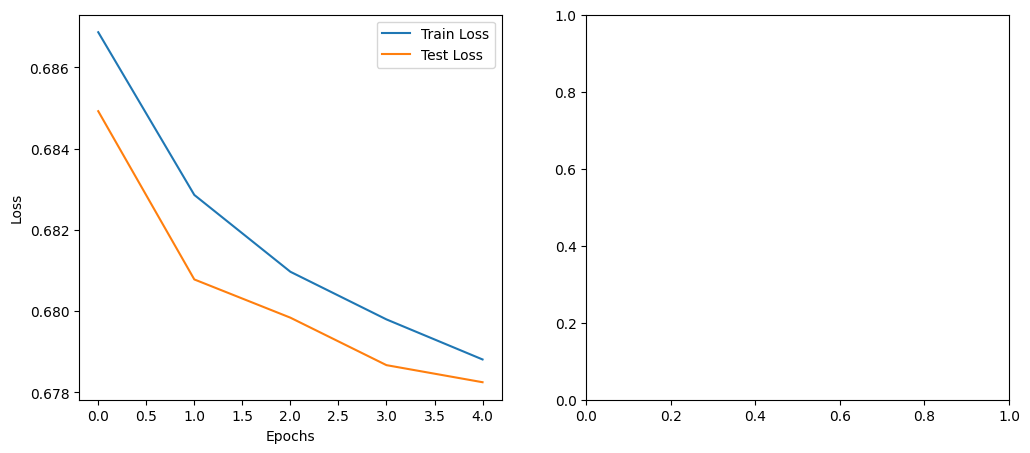

In [17]:
# VAmos a graficar los resultados
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(iou_scores, label='IOU Score')
plt.plot(jaccard_scores, label='Jaccard Score')
plt.plot(dice_scores, label='Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()
